## Introduction
Schneider (2016) estimates that 80% data is unstructured. This necessitates the development of techniques for analysing unstructured data. One such technique is Natural Language Processing (NLP). However, because it is hard to understand and find meaning in data that is text-heavy, companies have a difficult time creating insights that could ultimately shape decisions that are made within a company. When expressing their sentiments towards a company's products

This project is a machine learning project that utilises a dataset taken from [Kaggle](https://www.kaggle.com/chirin/the-zimbabwe-standard-headlines-and-previews). The original dataset contained only the date and the newspaper headline. However for the purposes of this project, I created another column which contains a category of the news headline, whether the headline is political or social.

### Objective
The aim of this project is to create a supervised learning, binary classification project which aims to classify news headlines into 2 categories based on the headline text.

## Ensuring model reproducibility

In [1]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [2]:
import pickle
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
import spacy
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from wordcloud import WordCloud

Using TensorFlow backend.


In [3]:
df=pd.read_csv('ZimStandardHeadlinesCleansed.csv')
df.head()

,Date,Headline,Category
0,1/14/2018,madiro faces revolt in manicaland,Political
1,1/14/2018,kadzuras wife demands share before estate is w...,Social
2,1/15/2018,reintroduce free primary education,Social
3,1/15/2018,we worked with chiwenga to topple mugabe chiefs,Political
4,1/15/2018,mugabe used excessive force to quash a rebelli...,Political


## Exploratory Data Analysis
This refers to all techniques applied to get more insights from the data. This includes the use of visualisations that summarise the data.

In [4]:
df.tail()

,Date,Headline,Category
705,2/3/2019,620 arrested in bulawayo,Social
706,2/3/2019,four acquitted over protests,Political
707,2/3/2019,sas da piles pressure on mnangagwa,Political
708,2/6/2019,bombing yugoslavia was it protection,Political
709,2/6/2019,us withdrawal from inf treaty to escalate tens...,Political


### Checking for missing values

In [5]:
df.shape

(710, 3)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 710 entries, 0 to 709
Data columns (total 3 columns):
Date        710 non-null object
Headline    710 non-null object
Category    710 non-null object
dtypes: object(3)
memory usage: 16.7+ KB


The shape of the dataset is 710 rows and 3 columns. The df.info() code shows us that all 3 columns have 710 non-null columns. Therefore it is evident that there are no missing values in the dataset

### Exploring the text in the 2 headline categories

In [7]:
df.groupby('Category').head()

,Date,Headline,Category
0,1/14/2018,madiro faces revolt in manicaland,Political
1,1/14/2018,kadzuras wife demands share before estate is w...,Social
2,1/15/2018,reintroduce free primary education,Social
3,1/15/2018,we worked with chiwenga to topple mugabe chiefs,Political
4,1/15/2018,mugabe used excessive force to quash a rebelli...,Political
5,1/21/2018,zim illprepared for climate change,Social
6,1/21/2018,khupe mudzuri and chamisa who will take the md...,Political
7,1/21/2018,expats offer free heart testing at chinhoyi ho...,Social
8,1/21/2018,zec ready for elections says ziyambi,Political
10,1/21/2018,man granted peace against disrespectful son,Social


### Number of Headlines in each category

In [8]:
print(df[ df['Category'] == 'Political'].shape)
print(df[ df['Category'] == 'Social'].shape)

(387, 3)
(323, 3)


In [9]:
df.dtypes

Date        object
Headline    object
Category    object
dtype: object

In [10]:
## keeping only relevant columns
df=df.drop('Date',axis=1)

### Visualising the most frequent words

In [11]:
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  
  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
  
  # selecting top n most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

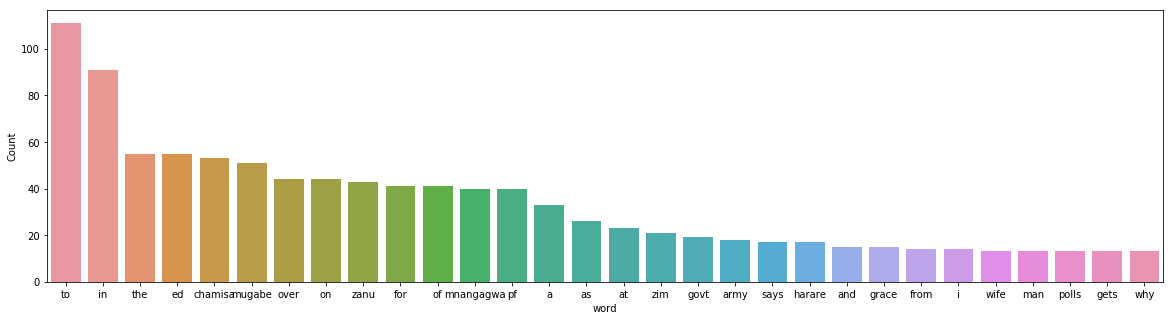

In [12]:
freq_words(df['Headline'])

From the above analysis, one can deduce that the most frequent words in the dataset are words that have litle effect on meaning. Words such as "to, in, the" have to be dropped to improve the acurace of the model.

## Feature Engineering

In [13]:
nlp = spacy.load('en_core_web_sm')
nlp.vocab['however'].is_stop = False
nlp.vocab['no'].is_stop = False
nlp.vocab['not'].is_stop = False
nlp.vocab['but'].is_stop = False
nlp.vocab['ve'].is_stop = True

### Removing stop words and tokenizing

In [14]:
def strip_stopwords(Headline):
    s = []
    for r in tqdm(Headline):
        s_2 = []
        for token in r:
            if nlp.vocab[token].is_stop == True:
                continue
            else:
                s_2.append(token)
        s.append(" ".join(s_2))    
        
    return s

def tokenization(x):
    Headline_tokens = []
    for i in tqdm(x):
        i = nlp(i)
        temp = []
        for j in i:
            temp.append(j.text)
        Headline_tokens.append(temp)
    
    return Headline_tokens

In [15]:
df['Headline'] = tokenization(df['Headline'])

100%|██████████| 710/710 [00:15<00:00, 45.75it/s]


In [16]:
df['Headline']=strip_stopwords(df['Headline'])

100%|██████████| 710/710 [00:00<00:00, 34541.84it/s]


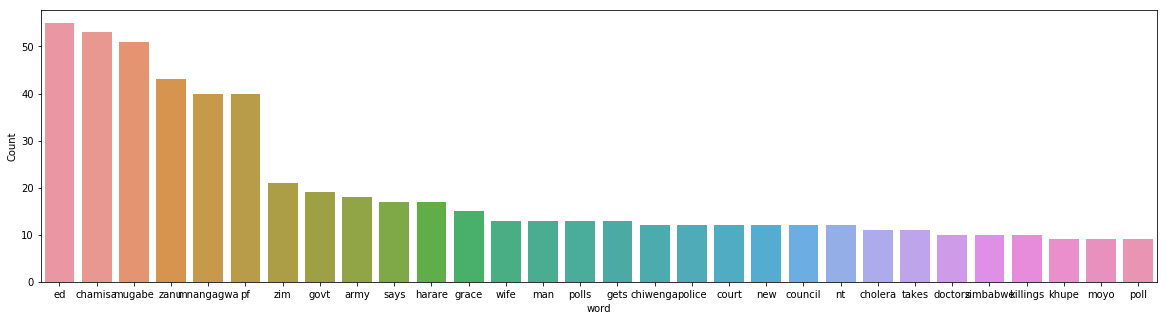

In [17]:
freq_words(df['Headline'])

In [18]:
def word_cloud(text):
    #We get the directory that we are working on
    x, y = np.ogrid[:300, :300]
    mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
    mask = 255 * mask.astype(int)
    #We read the mask image into a numpy array
    #avengers_mask = np.array(Image.open(os.path.join(file, "avengers.png")))
    #We generate the wordcloud using the series created and the mask 
    word_cloud = WordCloud(width=2000, height=1000, max_font_size=200, 
                           background_color="black", max_words=2000, mask=mask, 
                           contour_width=1, contour_color="steelblue", 
                           colormap="nipy_spectral").generate(text)

    #Now we plot the figure
    plt.figure(figsize=(10,10))
    plt.imshow(word_cloud, interpolation="hermite")
    plt.axis("off")    
    plt.show()   

### Word cloud for the dataset
a word cloud an image composed of words used in a particular text or subject, in which the size of each word indicates its frequency.

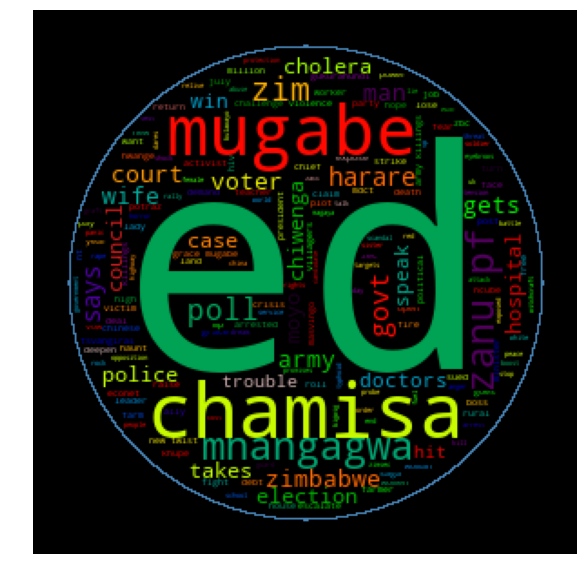

In [19]:
word_cloud(pd.Series([t for t in df.Headline]).str.cat(sep=' '))      

As can be seen above, after removing stop words the visualisation of frequent words consists of the more meaningful words

### Word cloud for political headlines

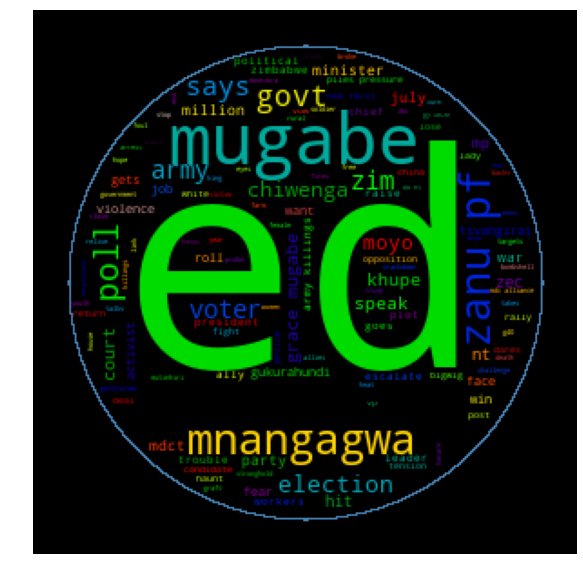

In [20]:
word_cloud(pd.Series([t for t in df[ df['Category'] == 'Political'].Headline]).str.cat(sep=' '))


### Word cloud for Social Headlines

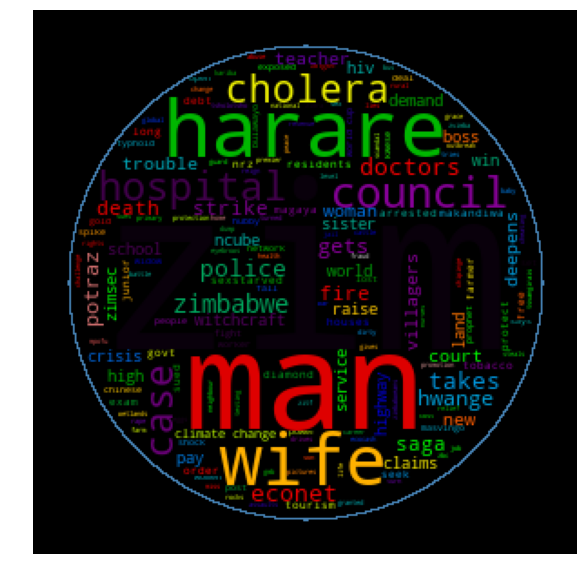

In [21]:
word_cloud(pd.Series([t for t in df[ df['Category'] == 'Social'].Headline]).str.cat(sep=' '))

In [22]:
df.head()

,Headline,Category
0,madiro faces revolt manicaland,Political
1,kadzuras wife demands share estate wound,Social
2,reintroduce free primary education,Social
3,worked chiwenga topple mugabe chiefs,Political
4,mugabe excessive force quash rebellion dabengwa,Political


### Encoding categorical variables

In [23]:
le=LabelEncoder()
df['Category']=le.fit_transform(df['Category'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fed460639b0>]],
      dtype=object)

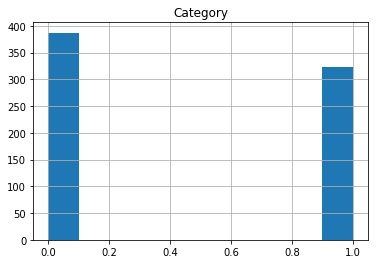

In [24]:
df.hist()

In [25]:
df.head()

,Headline,Category
0,madiro faces revolt manicaland,0
1,kadzuras wife demands share estate wound,1
2,reintroduce free primary education,1
3,worked chiwenga topple mugabe chiefs,0
4,mugabe excessive force quash rebellion dabengwa,0


### Splitting the data
Since this project is a supervised learning project, the data has to be split into Features: X and labels: y. Furthermore the data has to be split into 
* Training data - where the model is shown both the features and the labels
* Test data - the labels are known but not shown. This will be used to evaluate the model

In [26]:
from sklearn.model_selection import train_test_split
X=df.Headline
y=df.Category.values
print(X.shape)
print(y.shape)

(710,)
(710,)


In [27]:
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.1, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(639,)
(71,)
(639,)
(71,)


### Vectorising the text for use in model

In [28]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# tfidfvect = TfidfVectorizer()
# X_train_dtm=tfidfvect.fit_transform(X_train)
# X_train_dtm

In [29]:
# X_test_dtm=tfidfvect.fit_transform(X_test)
# X_test_dtm

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(binary=True)
X_train_dtm = vect.fit_transform(X_train)
X_train_dtm

<639x1605 sparse matrix of type '<class 'numpy.int64'>'
	with 3022 stored elements in Compressed Sparse Row format>

In [31]:
X_test_dtm=vect.transform(X_test)
X_test_dtm

<71x1605 sparse matrix of type '<class 'numpy.int64'>'
	with 210 stored elements in Compressed Sparse Row format>

In [32]:
# X_test_dtm = vect.fit_transform(X_test)
# X_test_dtm.shape

In [33]:
y_test

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 0])

## Creating the model
Every machine learning algorithm has three components:

* Representation: how to represent knowledge. Examples include decision trees, sets of rules, instances, graphical models, neural networks, support vector machines, model ensembles and others. The model used for this project is a neural network
* Evaluation: the way to evaluate candidate programs (hypotheses). Examples include accuracy, prediction and recall, squared error, likelihood, posterior probability, cost, margin, entropy k-L divergence and others. Since this project is a classification project, the accuracy metrics used are:
    * Accuracy
    * Precision
    * Recall
    * F1 score
  A classification report will be used to plot the metrics.
* Optimization: the way candidate programs are generated known as the search process. Adaptive momentum gradient descent is the optimizer of choice for this project.

Since this is a binary classification I used the Sigmoid activation fuction

### Preventing Overfitting
Earlystopping and ModelCheckpoint were applied to combat model overfitting. ModelCheckpoint monitored validation accuracy while Earlystopping monitored Validation Loss.

Model Checkpointing was used tosave the best performing model.

In [34]:
model = Sequential()
model.add(Dense(512, input_dim=X_train_dtm.shape[1],  activation='relu'))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.


In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               822272    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 1,873,409
Trainable params: 1,873,409
Non-trainable params: 0
_________________________________________________________________


### Model Architecture

In [36]:
plot_model(model, to_file='txt.png',show_shapes=True,)

![model](txt.png)

In [37]:
model.compile(loss='binary_crossentropy', optimizer= 'Adam', metrics=['accuracy'])

In [38]:
check = ModelCheckpoint("txt.h5",
                        monitor='val_acc',
                        verbose=1,
                        save_best_only=True,
                        save_weights_only=False)

In [39]:
early = EarlyStopping(monitor='val_loss',
                      patience=5,
                      verbose=1)

In [40]:
history = model.fit(X_train_dtm, y_train, epochs=20,
                     batch_size=100,
                     validation_split=0.1,
                   callbacks=[check, early])

Train on 575 samples, validate on 64 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
500/575 [=========================>....] - ETA: 0s - loss: 0.6825 - acc: 0.5380
Epoch 00001: val_acc improved from -inf to 0.71875, saving model to txt.h5
575/575 [==============================] - 2s 4ms/sample - loss: 0.6765 - acc: 0.5496 - val_loss: 0.5955 - val_acc: 0.7188
Epoch 2/20
500/575 [=========================>....] - ETA: 0s - loss: 0.4087 - acc: 0.8780
Epoch 00002: val_acc improved from 0.71875 to 0.82812, saving model to txt.h5
575/575 [==============================] - 1s 1ms/sample - loss: 0.3794 - acc: 0.8904 - val_loss: 0.3599 - val_acc: 0.8281
Epoch 3/20
500/575 [=========================>....] - ETA: 0s - loss: 0.0354 - acc: 0.9920
Epoch 00003: val_acc improved from 0.82812 to 0.87500, saving model to txt.h5
575/575 [==============================] - 1s 2ms/sample - loss: 0.0309 - acc: 0.9930 - val_loss: 0.3598 - val_acc: 0.8750
Epoch 4/20
500/575 [==============

## Model evaluation
For model evaluation, the model saved through model checkpointing was used. The model evaluation was done with the aid of a classification report which shows the various performance metrics for a classification algorithm.

In [41]:
txt=load_model('txt.h5')

### Confusion matrix for Train data

In [42]:
def plot_confusion_matrix(txt, X_train, y_train):
    y_pred = model.predict_classes(X_train, verbose=0)
    plt.figure(figsize=(8, 6))
    sns.heatmap(pd.DataFrame(confusion_matrix(y_train, y_pred)), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)

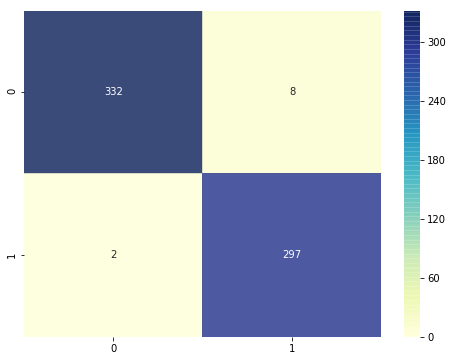

In [43]:
plot_confusion_matrix(txt, X_train_dtm, y_train)

### Classification report for training data

In [44]:
y_pred=txt.predict_classes(X_train_dtm, verbose=0)
print(classification_report(y_pred,y_train))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       344
           1       0.98      1.00      0.99       295

   micro avg       0.99      0.99      0.99       639
   macro avg       0.99      0.99      0.99       639
weighted avg       0.99      0.99      0.99       639



In [45]:
y_pred
pred=y_pred.ravel()
pred

array([0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,

In [46]:
X_train[(pred==1) & (y_train==0)]

497    zbc sued 62k hospitality debt
Name: Headline, dtype: object

In [47]:
X_train[(pred==0) & (y_train==1)]

627                   drought ravages mat south masvingo
7      expats offer free heart testing chinhoyi hospital
141                       gossip lands neighbour trouble
583    shock 16 students fall pregnant chirumanzu school
37                   suspected poachers   police custody
Name: Headline, dtype: object

In [48]:
scores = txt.evaluate(X_train_dtm, y_train)
print("%s: %.2f%%" % (txt.metrics_names[1], scores[1]*100))

639/639 [==============================] - 1s 1ms/sample - loss: 0.0758 - acc: 0.9906
acc: 99.06%


### Classification report for test data

In [49]:
y_pred=txt.predict_classes(X_test_dtm)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96        49
           1       0.88      0.95      0.91        22

   micro avg       0.94      0.94      0.94        71
   macro avg       0.93      0.95      0.94        71
weighted avg       0.95      0.94      0.94        71



In [50]:
scores = txt.evaluate(X_test_dtm, y_test)
print("%s: %.2f%%" % (txt.metrics_names[1], scores[1]*100))

71/71 [==============================] - 0s 1ms/sample - loss: 0.5672 - acc: 0.9437
acc: 94.37%


## Analysis of findings
The model has an accuracy of 99% and 94% on train and test data respectively. The accuracy of the model would have been higher if the model were trained on a larger dataset.

### Political news incorrectly classified as Social
Due to insufficient training data the model failed to correctly classify the headlines below. The model has challenges classifying headlines concerning political violence. From the word clouds constructed earlier, one can see that these headlines contain words that are frequently appearing in the Social headline category. With more data the model would have been able to learn morre patterns in the data.

In [51]:
pred=y_pred.ravel()
X_test[(pred==1) & (y_test==0)]

701    crackdown women relive rape ordeal
Name: Headline, dtype: object

### Political news incorrectly classified as political

In [52]:
X_test[(pred==0) & (y_test==1)]

598                           bus inferno 33 not 42 dead
47                      parents challenge exam rewriting
543    machete killings marauding gold panners strike...
Name: Headline, dtype: object

### Comparing model performance to machine learning models
The training data was fitted on shallow network models and the performance metrics were documented below

/home/don/anaconda3/envs/don/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


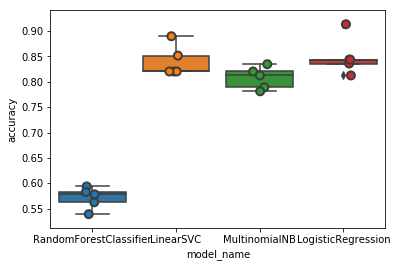

In [53]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X_train_dtm, y_train, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()


In [54]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.840453
LogisticRegression        0.849865
MultinomialNB             0.807554
RandomForestClassifier    0.571223
Name: accuracy, dtype: float64

The deep learning model outperformed the shallow network models. The deep learning model has an acuracy of 94% whereas the best performing shallow network model, (Logistic Regression) has an average accurary of 85%

### Logistic Regression classification matrix

In [55]:
lr = LogisticRegression()
lr.fit(X_train_dtm, y_train)
y_preds = lr.predict(X_test_dtm)
print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

           0       0.90      0.81      0.85        47
           1       0.69      0.83      0.75        24

   micro avg       0.82      0.82      0.82        71
   macro avg       0.80      0.82      0.80        71
weighted avg       0.83      0.82      0.82        71



### Deep learning Classification report

In [56]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96        47
           1       0.95      0.88      0.91        24

   micro avg       0.94      0.94      0.94        71
   macro avg       0.95      0.93      0.94        71
weighted avg       0.94      0.94      0.94        71



### Model accuracies of both models

In [57]:
scored=metrics.accuracy_score(y_test, y_preds)
print('Logistic Regression model accuracy',"%.2f%%" % (scored*100))
print('Deep learning model',"%s: %.2f%%" % (txt.metrics_names[1], scores[1]*100))

Logistic Regression model accuracy 81.69%
Deep learning model acc: 94.37%


## Conclusion
Text analysis is an important field of study since a large component of data is available in the form of text. This project can be applied to sentiment analysis.
